<a href="https://colab.research.google.com/github/Sinamhd9/Computer-vision-projects/blob/main/GMM/GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian mixture model (GMM) Clustering

In [1]:
# Importing required libraries
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import imageio
import os
from IPython.display import Image

## kmeans for Initialization

Below is Kmeans algorithm. We use Kmeans on the data to find the initial centers for our GMM algorithm.

In [2]:
def kmeans(data, k, max_iter=100, r = 10):
  m, n = data.shape
  all_dists = []
  all_clusters = []
  all_centers = []
  errors = []
  for init in range(r):
    idx = np.random.randint(m, size = k)
    clusters= np.zeros((m,))
    distances = np.zeros((m, k))
    centers = data[idx, :]
    diff = 1
    iter = 0
    while (diff!=0 and iter<max_iter):
      distances= cdist(data, centers)
      diff = np.sum(np.argmin(distances, axis=1) - clusters)
      clusters = np.argmin(distances, axis=1)
      for i in range(k):
        centers[i] = data[clusters==i].mean(axis=0)
      iter+=1

    errors.append(np.sum(np.square(np.min(distances, axis=1))))
    all_dists.append(distances)
    all_clusters.append(clusters)
    all_centers.append(centers)

  best_cluster = all_clusters[np.argmin(errors)]
  best_center = all_centers[np.argmin(errors)]
  best_distance = all_dists[np.argmin(errors)]
  return best_cluster, best_center, best_distance, np.min(errors) 

We run the Kmeans algorithm r=10 times to obtain the best possible cluster and centriods. 

In [3]:
data = np.loadtxt('510_cluster_dataset.txt')
m, d = data.shape
k = 3
init_idx, init_centers, _ , _ = kmeans(data, k=3, max_iter=100, r=10)

Here is Kmeans result on  our 2d dataset with k=3

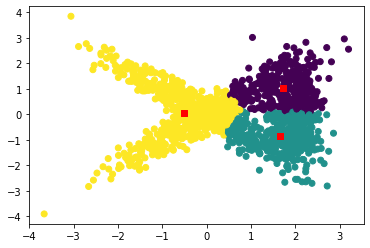

In [4]:
plt.scatter(data[:, 0], data[:,1], c= init_idx)
plt.scatter(init_centers[:, 0], init_centers[:, 1], c='r', marker='s')
plt.show()

## E-step and M-step

Here we define the required functions to implement GMM. 

In [5]:
def gaussian(x, mu, sigma):
  d = len(mu)
  x_meanZero = np.matrix(x - mu)
  return (1 / np.sqrt((((2*np.pi) ** d)* np.linalg.det(sigma))))* np.exp(-0.5 * np.einsum('...k,kl,...l->...',x_meanZero,np.linalg.inv(sigma),x_meanZero))

def E_step(x, k, mu, sigma, prior):
  d = x.shape[1]
  m = x.shape[0]
  post = np.zeros((m, k))
  for i in range(k):
    post[:, i] = prior[i] * gaussian(x, mu[i], sigma[i])
  sum_post = np.sum(post, axis=1)
  post /= sum_post[:,None]
  return post

def M_step(x, k, post):
  sigma = []
  prior =  np.sum(post, axis=0) / np.sum(post)
  mu = post.T @ x / np.sum(post, axis =0)[:,None]
  for i in range(k):
    s = ((1 / np.sum(post[:, i])) *  np.dot((post[:, i][:,None] * (x - mu[i])).T, (x - mu[i])))
    sigma.append(s)
  return mu, np.array(sigma), prior

def NLL(x, k, mu, sigma, prior):
  nll = np.zeros((x.shape[0]))
  for i in range(k):
    nll += prior[i]* gaussian(x, mu[i], sigma[i])
  nll = -np.sum(np.log(nll))
  return nll

## Main GMM

Here is the main GMM algorithm. The inputs are the data (x), number of clusters (k), number of different inits (r), max iteration and a threshold to stop the algorithm when NLL difference is low.

In [6]:
def GMM(x, k, r=10, max_iter=300, thre=0.05):
  all_mu = [[] for i in range(r)]
  all_sigma = [[] for i in range(r)]
  all_post = [[] for i in range(r)]
  d = x.shape[1]
  m = x.shape[0]
  for round in range(r):
    init_sigma  = np.zeros((k, d, d))
    init_prior = np.zeros((k,))
    init_post = np.zeros((m, k))
    init_idx, init_centers, _ , _ = kmeans(x, k=k, max_iter=100, r=10)
    for i in range(k):
      init_sigma[i] = np.cov(x[init_idx==i], rowvar=False)
      init_prior[i] = len(x[init_idx==i]) / len(x)
    post = E_step(x, k, init_centers, init_sigma, init_prior)
    diff = 100
    iter = 0
    er = 0
    while (iter < max_iter and diff > thre ):
      mu, sigma, prior = M_step(x, k, post)
      post =  E_step(x, k, mu, sigma, prior)
      diff = np.abs(er - NLL(x, k, mu, sigma, prior))
      er = NLL(x, k, mu, sigma, prior)
      all_mu[round].append(mu)
      all_sigma[round].append(sigma)
      all_post[round].append(post)
      iter+=1
      print('init {}'.format(round), 'iter {}'.format(iter), 'NLL:', er)
  return all_mu, all_sigma, all_post

## Test

Running GMM on our 2D dataset for r=10 rounds.

In [7]:
centers, sigma, poster = GMM(data, k=3, r=10, max_iter=500,  thre=0.05)

init 0 iter 1 NLL: 4497.555333185212
init 0 iter 2 NLL: 4482.401923321053
init 0 iter 3 NLL: 4470.874918081157
init 0 iter 4 NLL: 4461.546087013396
init 0 iter 5 NLL: 4454.280746996048
init 0 iter 6 NLL: 4448.861100756694
init 0 iter 7 NLL: 4444.946100643005
init 0 iter 8 NLL: 4442.175381778419
init 0 iter 9 NLL: 4440.231872747255
init 0 iter 10 NLL: 4438.866205472906
init 0 iter 11 NLL: 4437.8960485141415
init 0 iter 12 NLL: 4437.193661132844
init 0 iter 13 NLL: 4436.671499328114
init 0 iter 14 NLL: 4436.27012584141
init 0 iter 15 NLL: 4435.949264500747
init 0 iter 16 NLL: 4435.681559267021
init 0 iter 17 NLL: 4435.448338746588
init 0 iter 18 NLL: 4435.2367746691925
init 0 iter 19 NLL: 4435.037981061774
init 0 iter 20 NLL: 4434.8457404415685
init 0 iter 21 NLL: 4434.655646514618
init 0 iter 22 NLL: 4434.464523863368
init 0 iter 23 NLL: 4434.270032454732
init 0 iter 24 NLL: 4434.070395969517
init 0 iter 25 NLL: 4433.86421339885
init 0 iter 26 NLL: 4433.6503267797925
init 0 iter 27 NLL:

We can see by a specific threshold of 0.05, algorithm converges in less than 100 iterations. The results of different inits (r) are very similar because the defined Kmeans for programming 1 is returning the best init in terms of lowest error.  Below is the final mean and covariance matrix.

In [8]:
print('Final mu: ', centers[0][-1])
print('Final sigma: ', sigma[0][-1])

Final mu:  [[ 1.96516019e+00  1.01069932e-01]
 [-2.35605098e-04 -4.30283983e-02]
 [-8.46313283e-02  1.09006042e-01]]
Final sigma:  [[[ 0.10257197 -0.01250275]
  [-0.01250275  1.09474763]]

 [[ 1.0535545   0.99973158]
  [ 0.99973158  1.06883388]]

 [[ 1.06087807 -0.99004485]
  [-0.99004485  1.03763716]]]


### Animated visualization

Visualizing every 5 iterations in a specific init (r=0). 

In [9]:
file_names = []
for i in range(0, len(poster[0]), 2):
  clusters = poster[0][i].argmax(axis=1)
  plt.scatter(data[:, 0], data[:,1], c= clusters)
  plt.scatter(centers[0][i][:, 0], centers[0][i][:, 1], c='r', marker='s')
  plt.title('iter {}'.format(i))
  file_name = f"image{i}.png"
  file_names.append(file_name)
  plt.savefig(file_name)
  plt.close()

# Creating a gif with outputs
with imageio.get_writer('gmm.gif', mode='I') as writer:
    for name in file_names:
        image = imageio.imread(name)
        writer.append_data(image)


# Removing the created images for the gif
for files in set(file_names):
    os.remove(files)

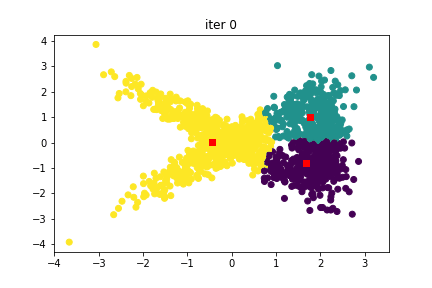

In [10]:
with open('gmm.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

The results are beautiful. The GMM algorithm detected a pattern in data that Kmeans can never achieve. 

Now, we perform image segmentation on the two provided images with our GMM algorithm.

## Image segmentation

In [11]:
img1 = cv2.imread('GMM_test1.jpg')
img2 = cv2.imread('GMM_test2.jpg') 

The previous GMM implementation saved all the iteration results which is not needed here. Therefore, I change the code a bit here. 

In [12]:
def GMM(x, k, r=10, max_iter=300, thre=0.05):
  all_mu = []
  all_sigma = []
  all_post = []
  d = x.shape[1]
  m = x.shape[0]
  for round in range(r):
    init_sigma  = np.zeros((k, d, d))
    init_prior = np.zeros((k,))
    init_post = np.zeros((m, k))
    init_idx, init_centers, _ , _ = kmeans(x, k=k, max_iter=100, r=10)
    for i in range(k):
      init_sigma[i] = np.cov(x[init_idx==i], rowvar=False)
      init_prior[i] = len(x[init_idx==i]) / len(x)
    post = E_step(x, k, init_centers, init_sigma, init_prior)
    diff = 100
    iter = 0
    er = 0
    while (iter < max_iter and diff > thre ):
      mu, sigma, prior = M_step(x, k, post)
      post =  E_step(x, k, mu, sigma, prior)
      diff = np.abs(er - NLL(x, k, mu, sigma, prior))
      er = NLL(x, k, mu, sigma, prior)
      iter+=1
      print('init {}'.format(round), 'iter {}'.format(iter), 'NLL:', er)
    all_mu.append(mu)
    all_sigma.append(sigma)
    all_post.append(post)
  return all_mu, all_sigma, all_post

## Results

### Image 1

Please note I used max iter of 500 and threshold of 0.1 for all Ks. Only 1 init is considered (r=1). 

#### K = 3 


In [ ]:
center1_k3, _, poster1_k3 = GMM(img1.reshape(-1,3), k= 3, r = 1, max_iter=500, thre = 0.1)

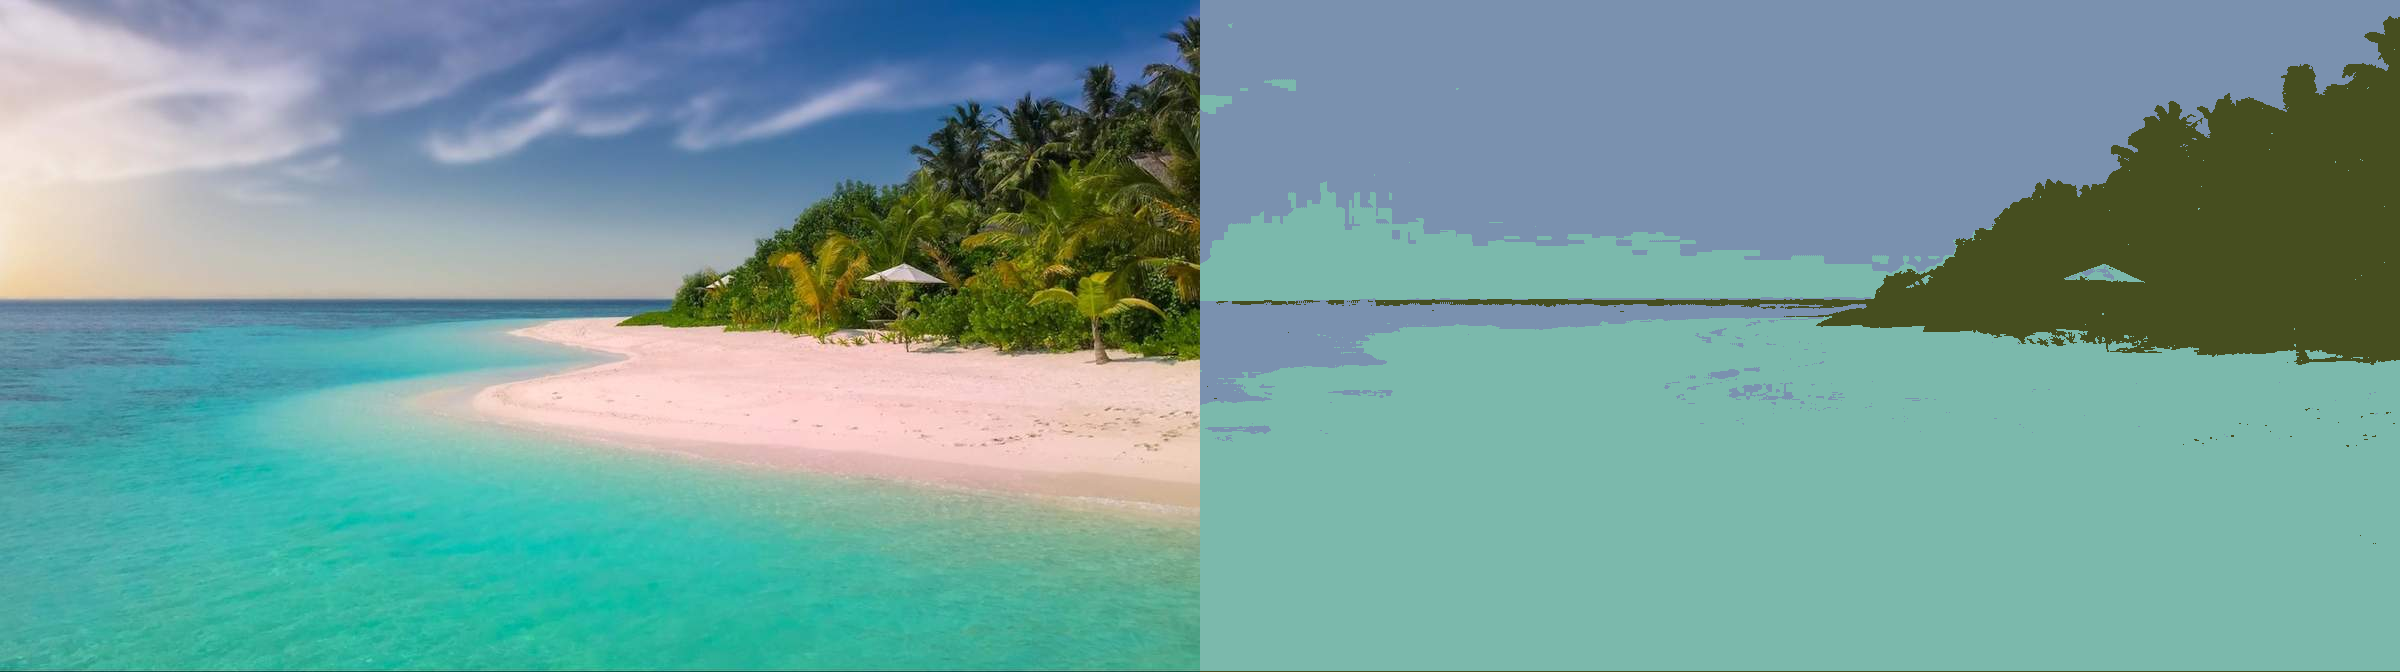

In [14]:
img1_seg_k3 = (center1_k3[0][poster1_k3[0].argmax(axis=1)]).reshape(img1.shape)
res_img1_k3 = np.concatenate((img1, img1_seg_k3), axis=1)
cv2_imshow(res_img1_k3)

#### K = 5

In [ ]:
center1_k5, _, poster1_k5 = GMM(img1.reshape(-1,3), k= 5, r = 1, max_iter=500, thre = 0.1)

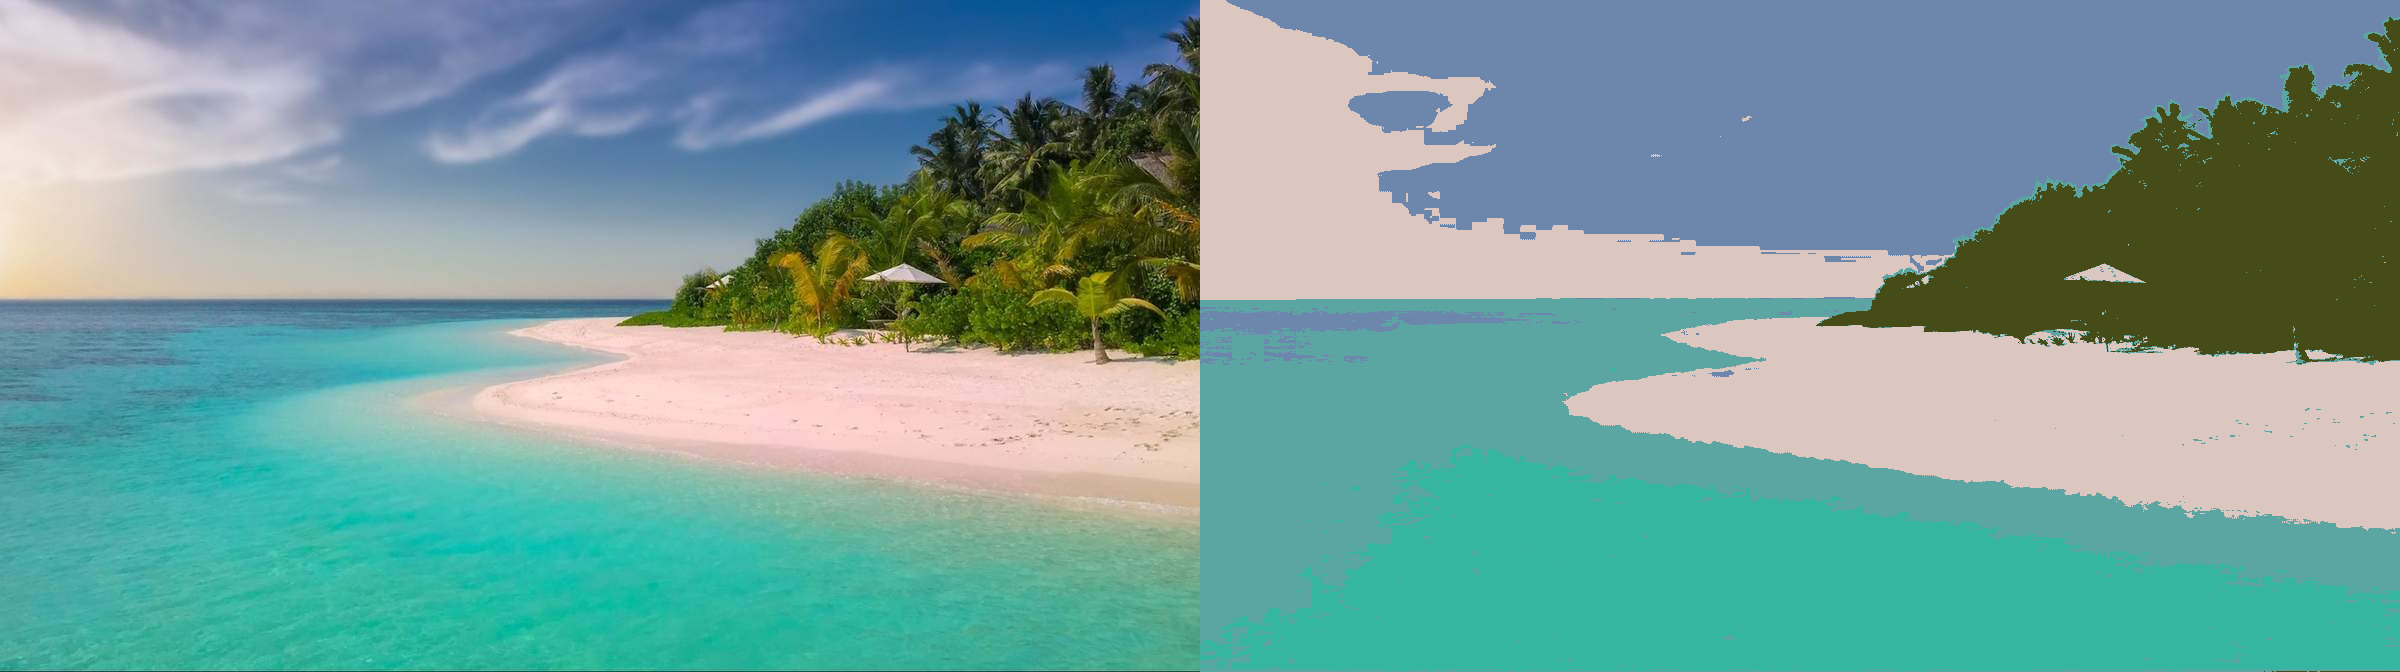

In [16]:
img1_seg_k5 = (center1_k5[0][poster1_k5[0].argmax(axis=1)]).reshape(img1.shape)
res_img1_k5 = np.concatenate((img1, img1_seg_k5), axis=1)
cv2_imshow(res_img1_k5)

#### K = 10

In [ ]:
center1_k10, _, poster1_k10 = GMM(img1.reshape(-1,3), k= 10, r = 1, max_iter=500, thre = 0.1)

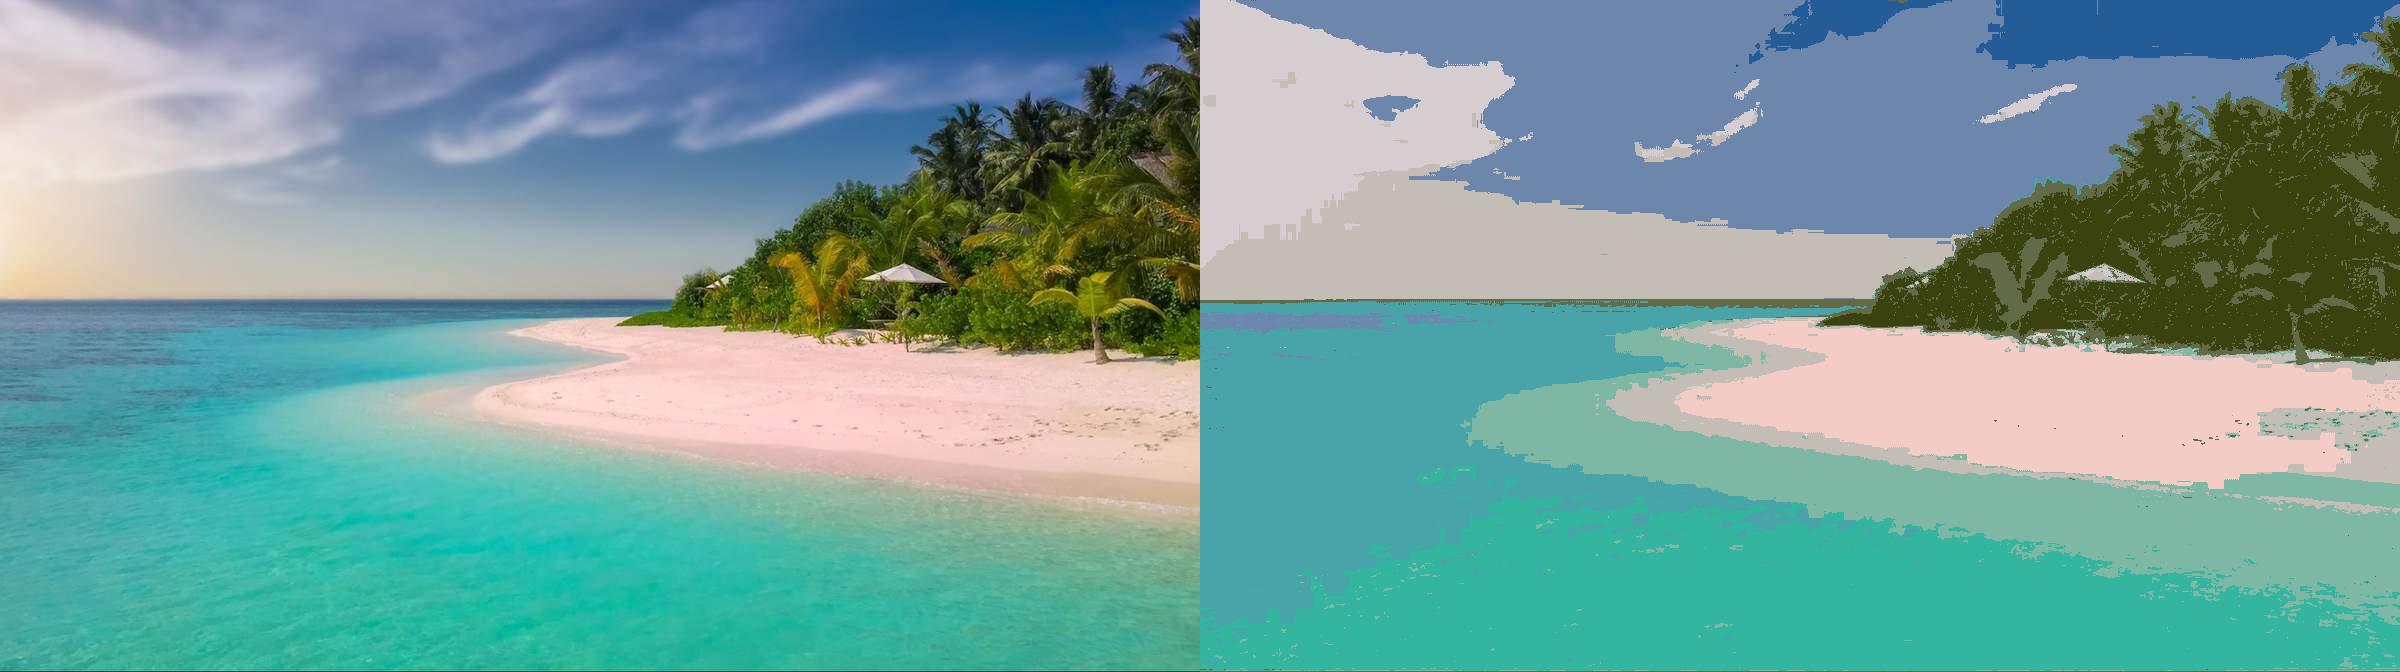

In [18]:
img1_seg_k10 = (center1_k10[0][poster1_k10[0].argmax(axis=1)]).reshape(img1.shape)
res_img1_k10 = np.concatenate((img1, img1_seg_k10), axis=1)
cv2_imshow(res_img1_k10)

### Image 2


#### K = 3

In [ ]:
center2_k3, _, poster2_k3 = GMM(img2.reshape(-1,3), k= 3, r = 1, max_iter=500, thre = 0.1)

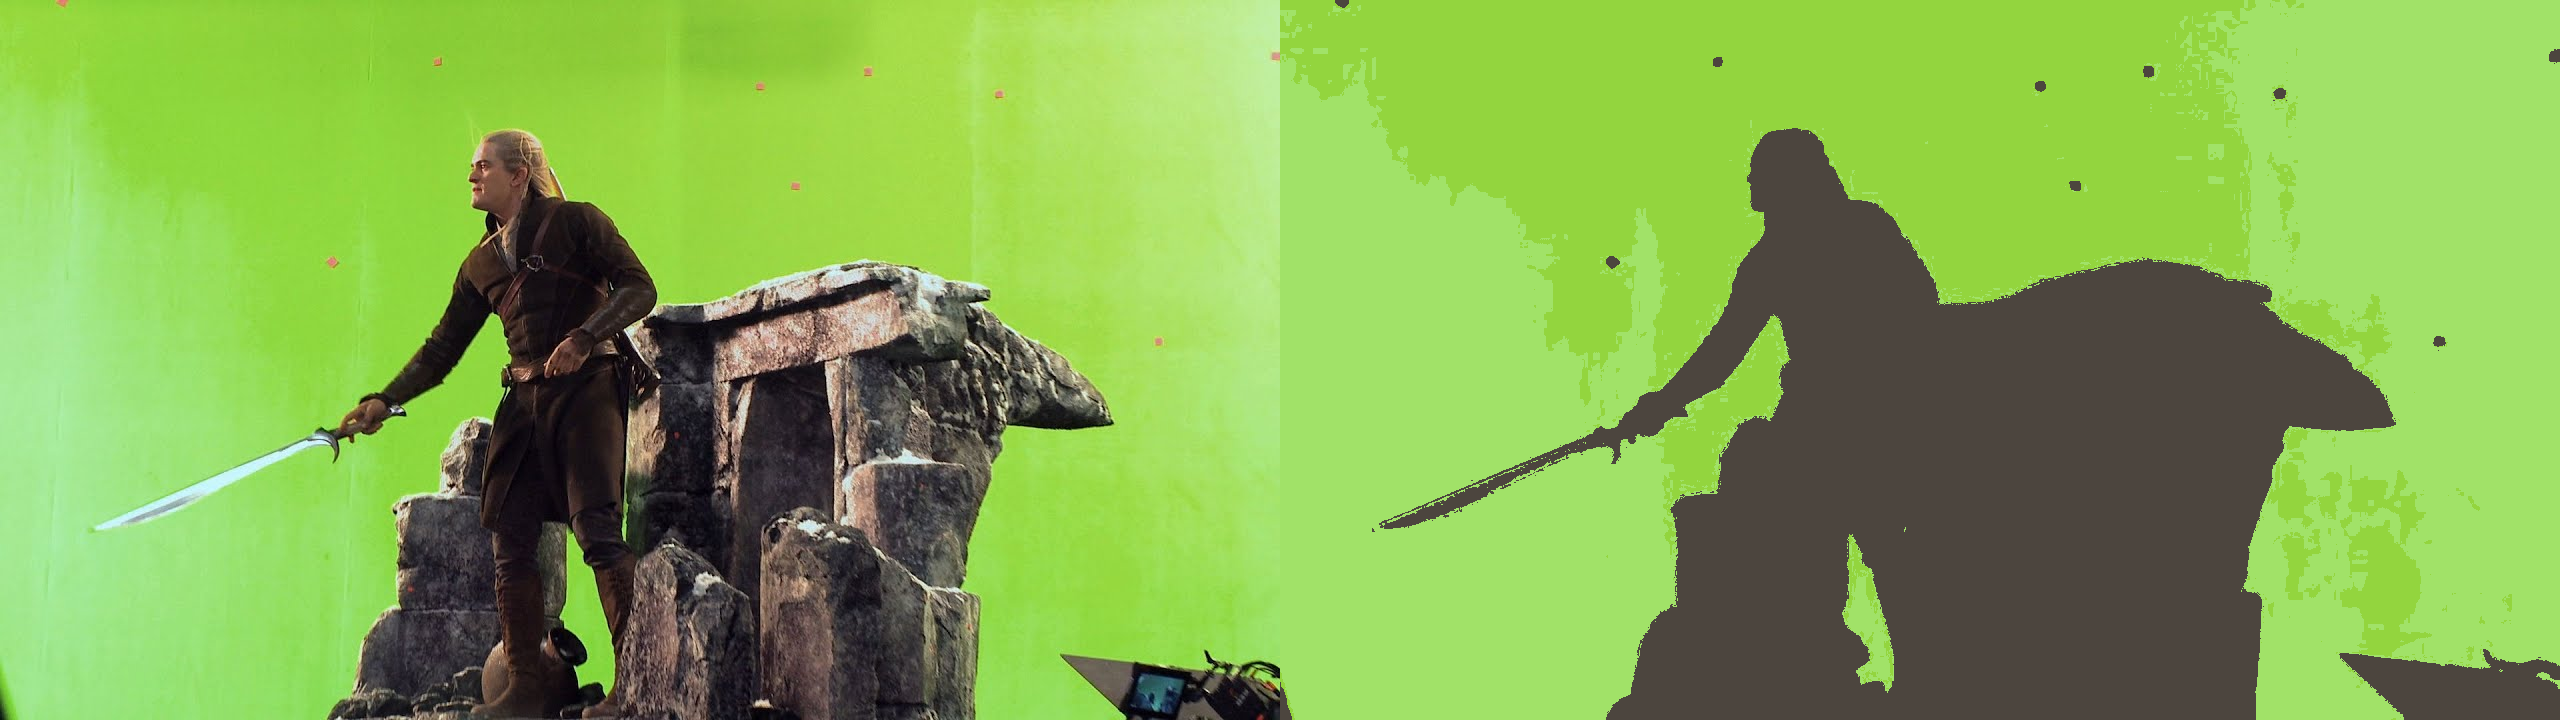

In [20]:
img2_seg_k3 = (center2_k3[0][poster2_k3[0].argmax(axis=1)]).reshape(img2.shape)
res_img2_k3 = np.concatenate((img2, img2_seg_k3), axis=1)
cv2_imshow(res_img2_k3)

#### K = 5

In [ ]:
center2_k5, _, poster2_k5 = GMM(img2.reshape(-1,3), k= 5, r = 1, max_iter=500, thre = 0.1)

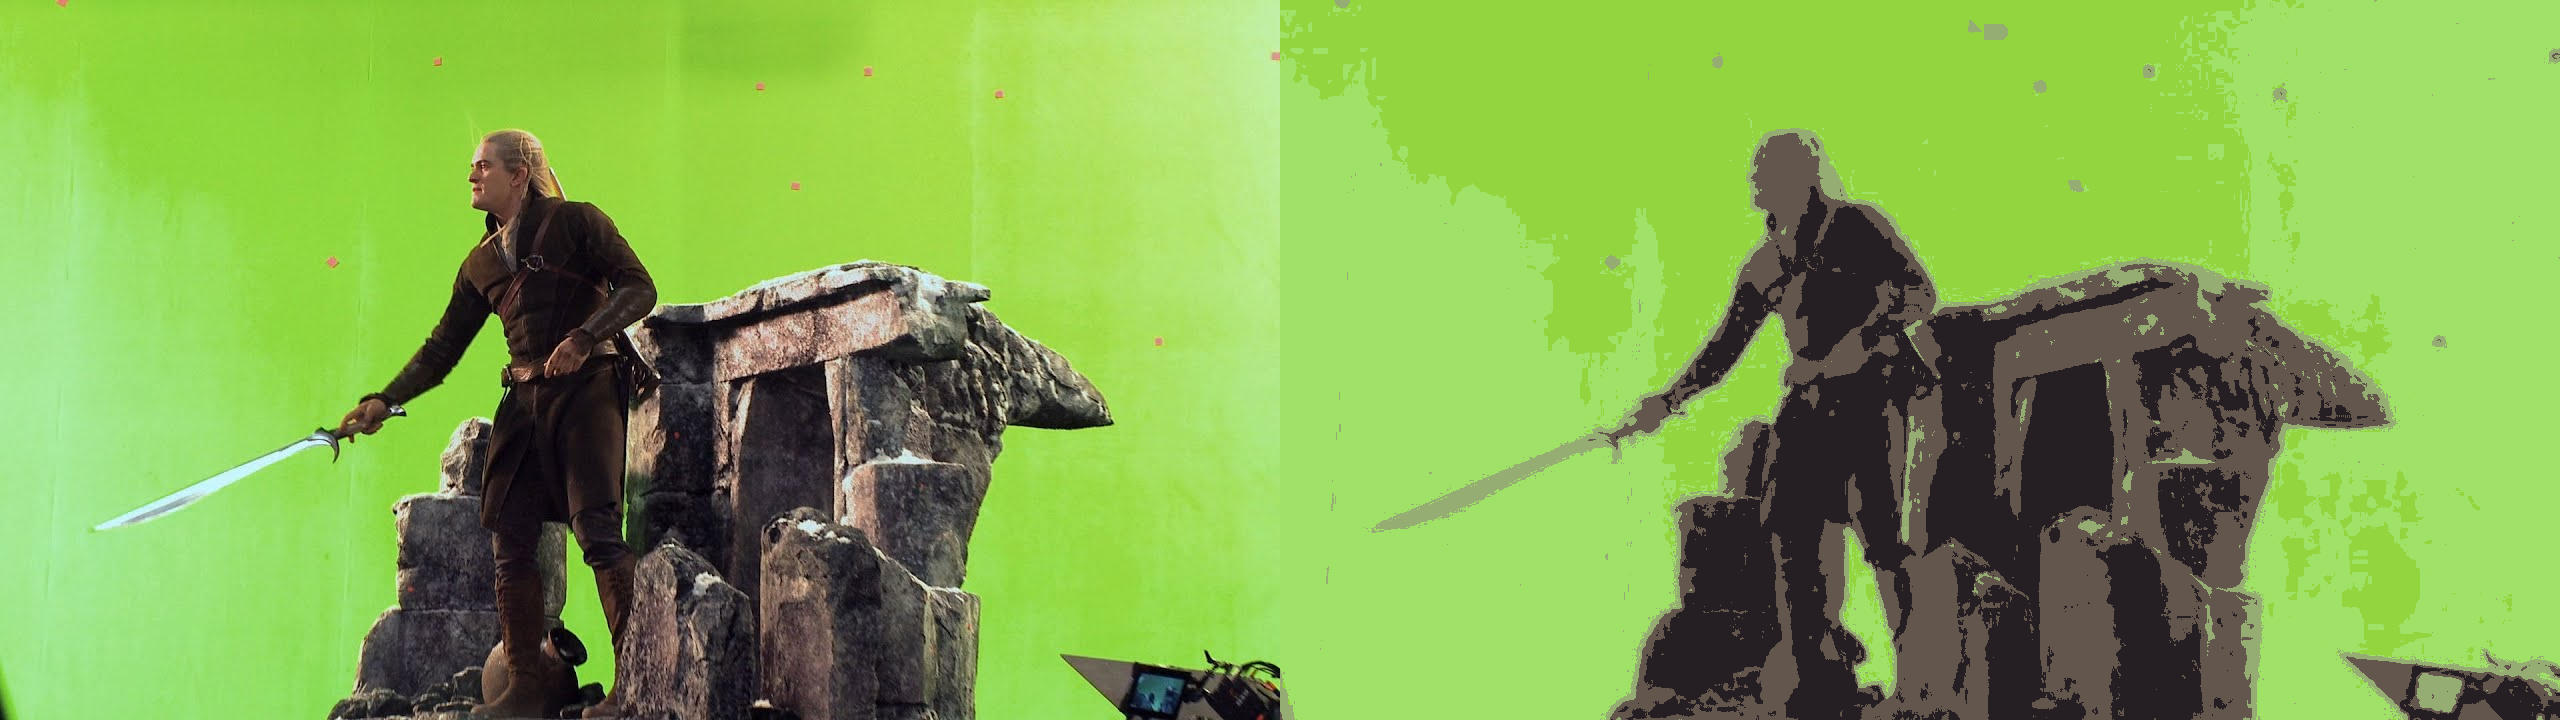

In [22]:
img2_seg_k5 = (center2_k5[0][poster2_k5[0].argmax(axis=1)]).reshape(img2.shape)
res_img2_k5 = np.concatenate((img2, img2_seg_k5), axis=1)
cv2_imshow(res_img2_k5)

#### K = 10

In [ ]:
center2_k10, _, poster2_k10 = GMM(img2.reshape(-1,3), k= 10, r = 1, max_iter=500, thre = 0.1)

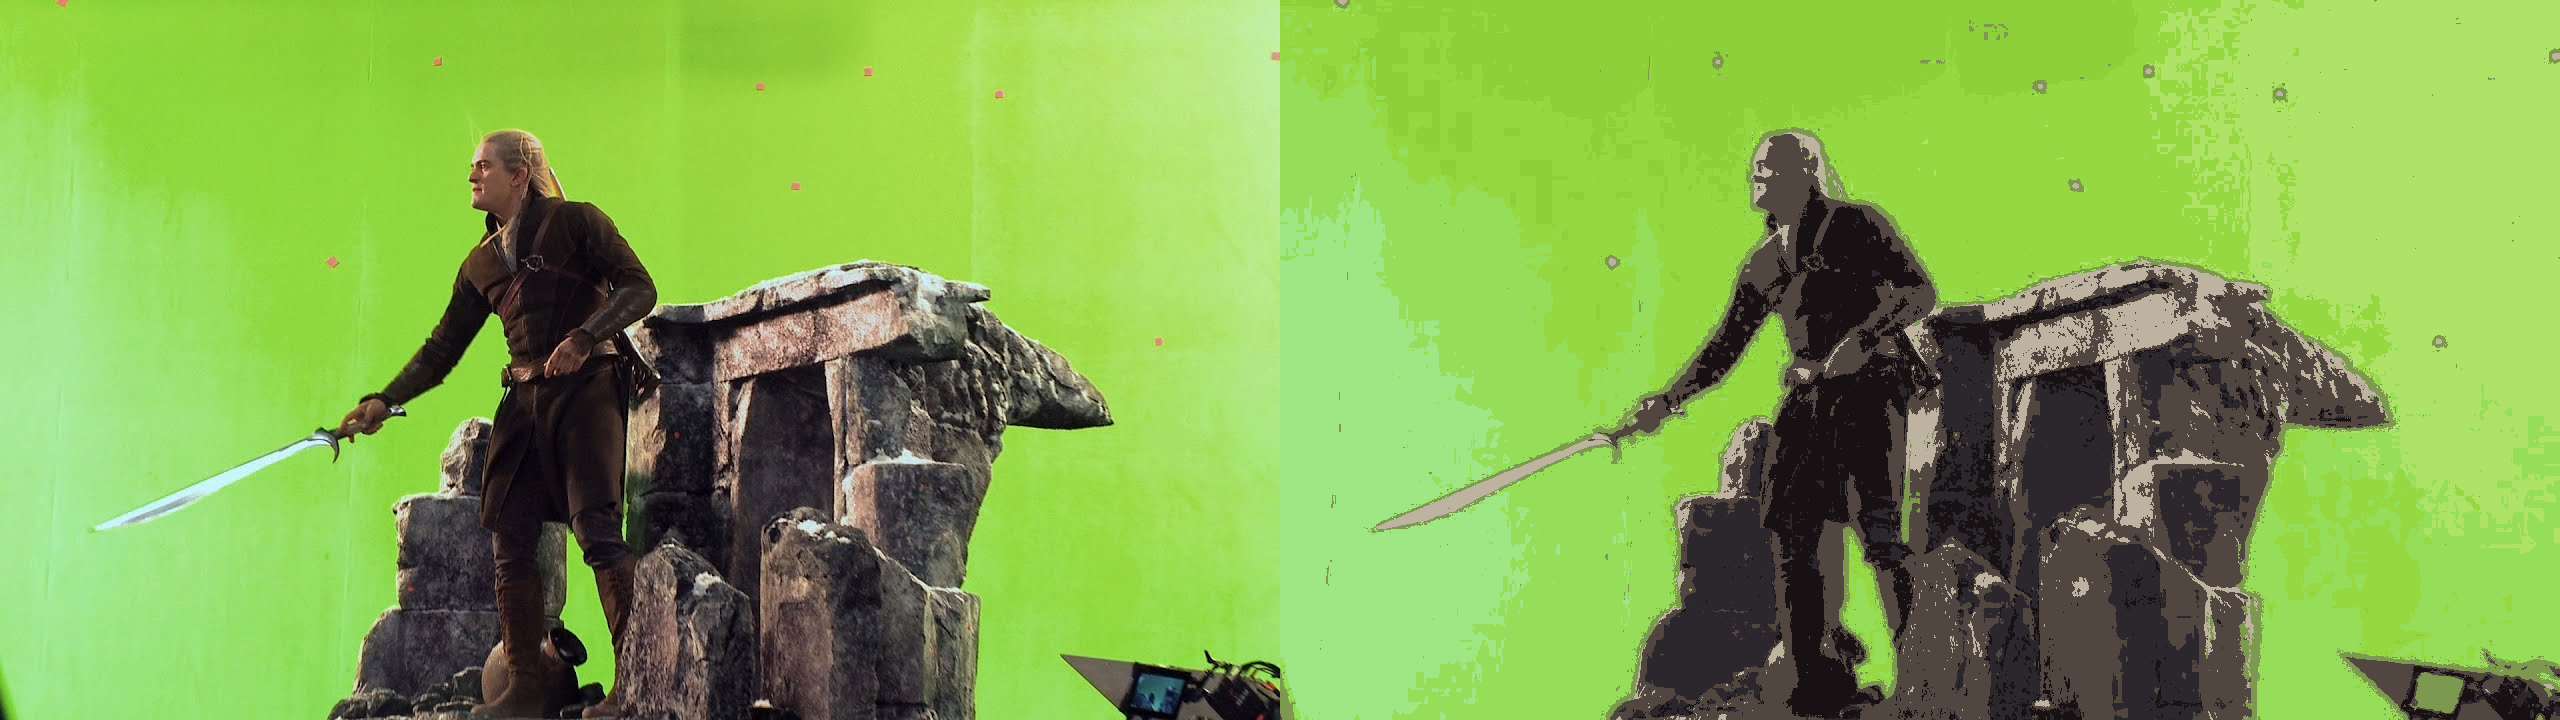

In [24]:
img2_seg_k10 = (center2_k10[0][poster2_k10[0].argmax(axis=1)]).reshape(img2.shape)
res_img2_k10 = np.concatenate((img2, img2_seg_k10), axis=1)
cv2_imshow(res_img2_k10)

We can see for a fixed threshold, increasing K results in more convergence time.